In [1]:
import sys
from pathlib import Path
from astropy.table import Table
import pandas as pd
import numpy as np
import json
import seaborn as sn

ROOT_PATH = Path("..")  # necessary since we are in the `notebooks/` sub-folder

Read the table of sources and convert to pandas dtaframe, using a query to exclude problematic and interproplyd sources:

In [2]:
qstring = "~((Group == '*P') | (Group == '*I'))"
df = (
    Table.read(
        ROOT_PATH / "luis-programas/arcs-summary-classify.ecsv", format="ascii.ecsv"
    )
    .to_pandas()
    .query(qstring)
)

In [3]:
df.columns

Index(['Object', 'h_old', 'Value_Bally', 'Value_bg_Bally', 'Delta',
       'Dif_Bally', 'Value_Robberto', 'Value_bg_Robberto_f656',
       'Dif_Robberto_f656', 'RA', 'Dec', 'D', 'PA_star', 'h', 'PA_out',
       'PA_in', 'R_out', 'R_in', 'Rc_out', 'Rc_in', 'Group'],
      dtype='object')

Make a new dataframe that just keeps the planitude and alatude from the old calculations, and then adds columns for the new `circle_fit` results.

In [4]:
df2 = df[["Object", "Group", "D", "PA_star", "h"]].assign(
    old_Pi_in=df.Rc_in / df.R_in, old_Pi_out=df.Rc_out / df.R_out,
)

Look at the mean and standard deviation by spatial group.

In [5]:
df2.groupby(by="Group").mean().sort_values(by="D")

,D,PA_star,h,old_Pi_in,old_Pi_out
Group,,,,,
LV,7.195143,195.371429,0.329857,2.108782,2.019316
SE,26.786500,304.275000,0.570500,1.364605,2.312926
N,47.760875,174.737500,0.414125,2.155561,2.218384
NW,147.507818,130.972727,0.788091,3.537161,3.144651
W,362.238042,66.412500,0.722083,3.007622,2.747627
S,466.909533,223.453333,1.521200,3.266147,3.089230


In [6]:
df2.groupby(by="Group").std().sort_values(by="D")

,D,PA_star,h,old_Pi_in,old_Pi_out
Group,,,,,
LV,1.104401,94.602849,0.178196,0.987191,0.681485
SE,8.364707,24.945056,0.271620,0.251511,1.515185
N,11.780138,28.212102,0.282055,0.809120,0.561276
NW,47.068761,26.491398,0.668043,2.379941,1.761767
S,108.786626,157.764435,1.140794,2.650913,1.979926
W,145.727773,15.887548,0.423186,1.292332,1.217820


In [7]:
# Keys in JSON file for each variable
VARS = "Pi", "Lambda", "d Lambda", "R0"  # , "d theta"
# And a parallel version for the table column names (no spaces!)
VVARS = [_.replace(" ", "_") for _ in VARS]


def mad(x):
    """Median absolute deviation rescaled to sigma for Gaussian"""
    return 1.4826 * np.nanmedian(np.abs(x - np.nanmedian(x)))


def collate_circle_fit_one_source(source_id):
    rslt = {"Object": source_id}

    for arc_long, arc in [["inner", "in"], ["outer", "out"], ["ridge", "out"]]:
        json_paths = sorted(ROOT_PATH.glob(f"*/{source_id}-{arc_long}-*.json"))
        try:
            rslt["Folder"] = str(json_paths[0].parent.name)
        except IndexError:
            rslt["Folder"] = ""
        # print(arc_long)
        # print(json_paths)
        # Initialize empty lists for each variable
        var_lists = {f"{vv}_{arc}": [] for vv in VVARS}

        # Now fill in those lists with data from JSON files
        # print(json_paths)
        if not json_paths:
            # But skip the rest if there is no data for this arc type
            continue

        rslt["Outer arc type"] = arc_long
        for json_path in json_paths:
            data = json.load(json_path.open())
            # print(data)
            if not 60 <= data["d theta"] <= 75:
                continue  # skip anything outside this range of d theta
            for v, vv in zip(VARS, VVARS):
                var_lists[f"{vv}_{arc}"].append(data.get(v))

        # Finally, calculate median and dispersion
        for vv in VVARS:
            key = f"{vv}_{arc}"
            vmedian = np.nanmedian(var_lists[key])
            vsig = mad(np.array(var_lists[key]))
            rslt[key] = vmedian
            rslt[f"e_{key}"] = vsig
            rslt[f"n_{key}"] = len(var_lists[key])
            # rslt[f"list_{key}"] = var_lists[key]

    return rslt

In theory, the `out` arc should be overwritten with data from `ridge` if it is available.  Hopefully, this will sort out the LV knots.

In [8]:
data = collate_circle_fit_one_source("LL7")
data

/Users/will/miniconda3/envs/science/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


{'Object': 'LL7',
 'Folder': '',
 'Outer arc type': 'outer',
 'Pi_in': 2.0506892926292934,
 'e_Pi_in': 0.9204797740772529,
 'n_Pi_in': 4,
 'Lambda_in': 3.7853682881344364,
 'e_Lambda_in': 1.3411049383096914,
 'n_Lambda_in': 4,
 'd_Lambda_in': nan,
 'e_d_Lambda_in': nan,
 'n_d_Lambda_in': 4,
 'R0_in': 117.80662198176971,
 'e_R0_in': 4.922707463359413,
 'n_R0_in': 4,
 'Pi_out': 3.1549733109754663,
 'e_Pi_out': 0.5265744126460519,
 'n_Pi_out': 4,
 'Lambda_out': 3.559353974055767,
 'e_Lambda_out': 0.013514609737807697,
 'n_Lambda_out': 4,
 'd_Lambda_out': -0.39963918235056306,
 'e_d_Lambda_out': 0.20403008771314585,
 'n_d_Lambda_out': 4,
 'R0_out': 152.86246123728074,
 'e_R0_out': 1.8203372410203542,
 'n_R0_out': 4}

In [9]:
data = collate_circle_fit_one_source("167-317")
data

{'Object': '167-317',
 'Folder': 'j8oc01010_wcs',
 'Outer arc type': 'ridge',
 'Pi_out': 2.2856327425826466,
 'e_Pi_out': 0.14624704523581566,
 'n_Pi_out': 4,
 'Lambda_out': 1.653609084708107,
 'e_Lambda_out': 0.011028732693717994,
 'n_Lambda_out': 4,
 'd_Lambda_out': nan,
 'e_d_Lambda_out': nan,
 'n_d_Lambda_out': 4,
 'R0_out': 29.380483159944752,
 'e_R0_out': 0.12685619640506465,
 'n_R0_out': 4}

In [10]:
df3 = pd.DataFrame(
    [collate_circle_fit_one_source(source_id) for source_id in df2["Object"]]
)
df3

,Object,Folder,Outer arc type,Pi_in,e_Pi_in,n_Pi_in,Lambda_in,e_Lambda_in,n_Lambda_in,d_Lambda_in,...,n_Pi_out,Lambda_out,e_Lambda_out,n_Lambda_out,d_Lambda_out,e_d_Lambda_out,n_d_Lambda_out,R0_out,e_R0_out,n_R0_out
0,022-635,,outer,3.101254,0.000000,4.0,NaN,NaN,4.0,NaN,...,4.0,NaN,NaN,4.0,NaN,NaN,4.0,22.700683,0.000000,4.0
1,041-637,,outer,4.450772,0.958192,4.0,2.381846,0.020438,4.0,NaN,...,4.0,1.790073,0.007428,4.0,NaN,NaN,4.0,38.138194,0.021015,4.0
2,042-628,,outer,1.947693,0.008822,4.0,1.811044,0.001372,4.0,NaN,...,4.0,1.900725,0.007162,4.0,NaN,NaN,4.0,62.632856,0.234756,4.0
3,049-143,,outer,1.060232,0.032640,4.0,1.098401,0.000175,4.0,NaN,...,4.0,NaN,NaN,4.0,NaN,NaN,4.0,25.791173,0.119471,4.0
4,051-024,,outer,1.645917,0.000000,4.0,2.141000,0.000000,4.0,NaN,...,4.0,1.769746,0.002080,4.0,NaN,NaN,4.0,24.115831,0.017468,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,w030-524,,outer,109.644635,139.344288,4.0,NaN,NaN,4.0,NaN,...,4.0,2.825181,0.001090,4.0,-0.627683,0.088839,4.0,12.250098,0.092689,4.0
65,w044-527,,outer,11.898118,0.000000,4.0,NaN,NaN,4.0,NaN,...,2.0,NaN,NaN,2.0,NaN,NaN,2.0,44.127823,0.000000,2.0
66,w069-601,,outer,4.019564,0.361252,4.0,2.718702,0.051402,4.0,-0.303279,...,4.0,2.193956,0.009023,4.0,-0.274620,0.020852,4.0,17.338515,0.022414,4.0
67,w073-227,,outer,3.409059,0.502573,4.0,3.307311,0.038912,4.0,NaN,...,4.0,2.863742,0.162548,4.0,NaN,NaN,4.0,32.015522,0.072132,4.0


In [11]:
dff = df2.merge(df3, how="outer", on="Object")
dff

,Object,Group,D,PA_star,h,old_Pi_in,old_Pi_out,Folder,Outer arc type,Pi_in,...,n_Pi_out,Lambda_out,e_Lambda_out,n_Lambda_out,d_Lambda_out,e_d_Lambda_out,n_d_Lambda_out,R0_out,e_R0_out,n_R0_out
0,022-635,W,286.472,47.7,0.341,3.053333,4.036232,,outer,3.101254,...,4.0,NaN,NaN,4.0,NaN,NaN,4.0,22.700683,0.000000,4.0
1,041-637,W,267.840,43.4,0.766,2.718251,2.268973,,outer,4.450772,...,4.0,1.790073,0.007428,4.0,NaN,NaN,4.0,38.138194,0.021015,4.0
2,042-628,W,259.592,44.5,1.339,2.048864,2.248615,,outer,1.947693,...,4.0,1.900725,0.007162,4.0,NaN,NaN,4.0,62.632856,0.234756,4.0
3,049-143,NW,197.821,120.2,0.560,1.059200,3.561807,,outer,1.060232,...,4.0,NaN,NaN,4.0,NaN,NaN,4.0,25.791173,0.119471,4.0
4,051-024,NW,245.010,136.7,0.269,1.858101,1.928331,,outer,1.645917,...,4.0,1.769746,0.002080,4.0,NaN,NaN,4.0,24.115831,0.017468,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,w030-524,W,234.087,58.6,0.315,5.350694,4.087859,,outer,109.644635,...,4.0,2.825181,0.001090,4.0,-0.627683,0.088839,4.0,12.250098,0.092689,4.0
65,w044-527,W,217.945,55.0,0.851,1.957692,1.525822,,outer,11.898118,...,2.0,NaN,NaN,2.0,NaN,NaN,2.0,44.127823,0.000000,2.0
66,w069-601,W,212.194,41.9,0.423,4.377778,3.192263,,outer,4.019564,...,4.0,2.193956,0.009023,4.0,-0.274620,0.020852,4.0,17.338515,0.022414,4.0
67,w073-227,NW,147.268,112.4,0.696,4.906289,3.974170,,outer,3.409059,...,4.0,2.863742,0.162548,4.0,NaN,NaN,4.0,32.015522,0.072132,4.0


In [12]:
columns_to_drop = [_ for _ in dff.columns if _.startswith("n_")]
dff.drop(columns_to_drop, axis=1, inplace=True)

In [13]:
dff.groupby(by="Group").mean().sort_values(by="D")

,D,PA_star,h,old_Pi_in,old_Pi_out,Pi_in,e_Pi_in,Lambda_in,e_Lambda_in,d_Lambda_in,...,R0_in,e_R0_in,Pi_out,e_Pi_out,Lambda_out,e_Lambda_out,d_Lambda_out,e_d_Lambda_out,R0_out,e_R0_out
Group,,,,,,,,,,,,,,,,,,,,,
LV,7.195143,195.371429,0.329857,2.108782,2.019316,2.917165,0.427330,NaN,NaN,NaN,...,23.048913,0.047605,7.613725,3.513614,2.052036,0.029407,-0.108504,0.001906,24.550145,0.058269
SE,26.786500,304.275000,0.570500,1.364605,2.312926,1.548540,0.026819,1.511953,0.014908,0.177473,...,27.690840,0.226360,1.713934,0.103580,2.184304,0.107427,NaN,NaN,44.773206,0.185274
N,47.760875,174.737500,0.414125,2.155561,2.218384,3.973437,0.740016,2.452401,0.136581,-4.133978,...,23.972556,0.436303,2.275919,0.208127,1.633134,0.022995,NaN,NaN,40.112012,0.169218
NW,147.507818,130.972727,0.788091,3.537161,3.144651,3.397833,0.581223,2.487346,0.067969,0.120433,...,22.124596,0.055266,3.226948,0.296749,2.588159,0.063238,0.036436,0.055480,36.141548,0.158079
W,362.238042,66.412500,0.722083,3.007622,2.747627,11.408273,11.033238,2.442433,0.055250,0.059764,...,21.303318,0.131799,2.628195,0.148862,2.282626,0.032842,-0.059143,0.031793,37.710066,0.183290
S,466.909533,223.453333,1.521200,3.266147,3.089230,3.225828,0.515869,2.426482,0.152560,0.378081,...,42.218215,0.569357,2.972824,0.246602,2.385022,0.032083,-0.189894,0.088325,74.869234,0.350441


In [55]:
dff_log = pd.concat(
    [
        dff[["Object", "Group"]],
        dff[["D"]].apply(np.log10),
        dff[["old_Pi_in", "old_Pi_out", "Pi_in", "Pi_out", "Lambda_in", "Lambda_out"]]
        .clip(lower=1.0, upper=15.0)
        .apply(np.log10),
    ],
    axis=1,
)

In [56]:
pd.options.display.max_rows = 100
dff_log

,Object,Group,D,old_Pi_in,old_Pi_out,Pi_in,Pi_out,Lambda_in,Lambda_out
0,022-635,W,2.457082,0.484774,0.605976,0.491537,0.562335,NaN,NaN
1,041-637,W,2.427875,0.434289,0.355829,0.648435,0.323065,0.376914,0.252871
2,042-628,W,2.414291,0.311513,0.351915,0.289521,0.257220,0.257929,0.278919
3,049-143,NW,2.296272,0.024978,0.551670,0.025401,0.419631,0.040761,NaN
4,051-024,NW,2.389184,0.269069,0.285181,0.216408,0.262696,0.330617,0.247911
5,066-3251,S,2.769001,NaN,0.172279,NaN,0.172027,NaN,0.074522
6,072-134,NW,2.242385,0.508189,0.574981,0.446766,0.448166,0.398070,0.321620
7,074-229,NW,2.160700,0.000000,0.071811,NaN,0.059127,NaN,NaN
8,101-233,NW,2.025044,0.299381,0.248506,0.288943,0.352022,NaN,NaN
9,102-157,NW,2.097941,0.945023,0.800655,0.625400,0.910793,0.409032,0.501053


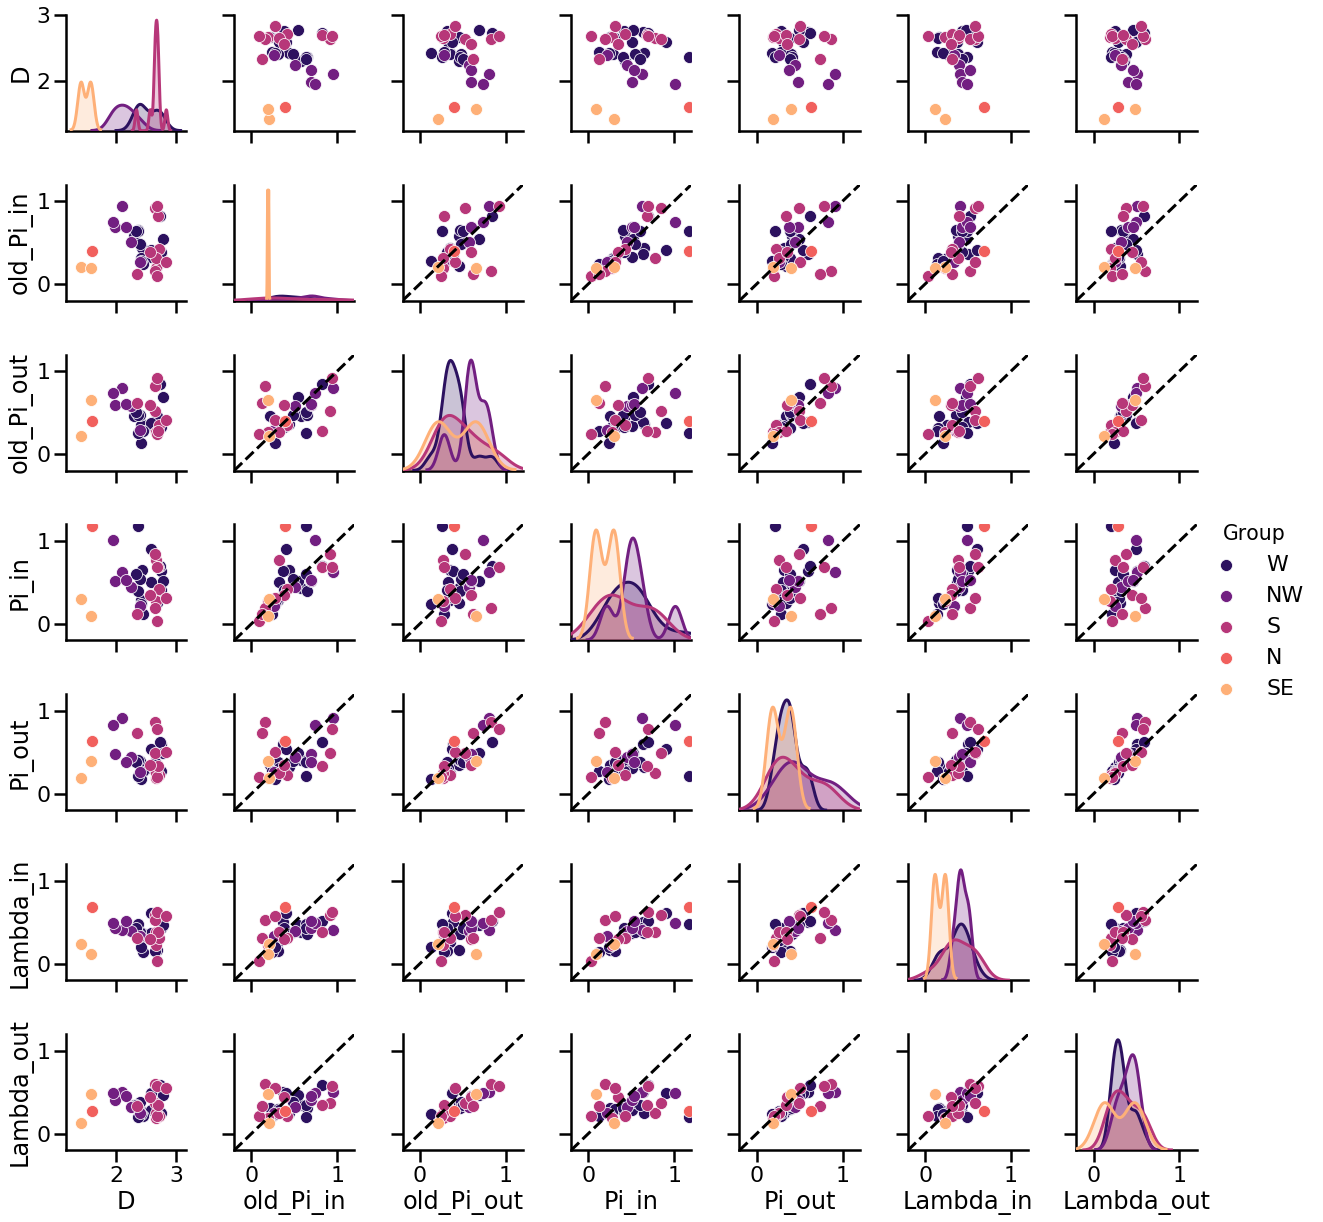

In [58]:
fig = sn.pairplot(dff_log.dropna(), hue="Group", palette="magma")
for i, row in enumerate(fig.axes):
    for j, ax in enumerate(row):
        if i != j and i != 0 and j != 0:
            ax.set(xlim=[-0.2, 1.2], ylim=[-0.2, 1.2])
            ax.plot([-0.2, 1.2], [-0.2, 1.2], "--", c="k")

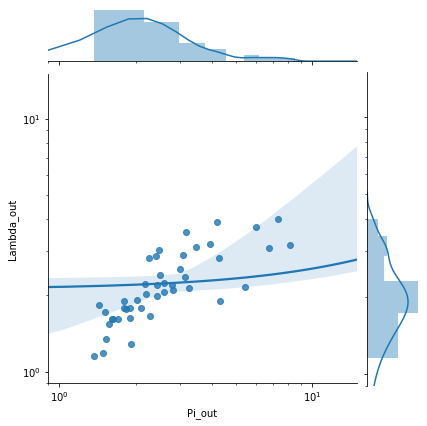

In [17]:
ax = sn.jointplot(dff["Pi_out"], dff["Lambda_out"], kind="reg")
ax.ax_joint.set(xlim=[0.9, 15.0], ylim=[0.9, 15.0], xscale="log", yscale="log")
ax.ax_joint.set_aspect("equal")

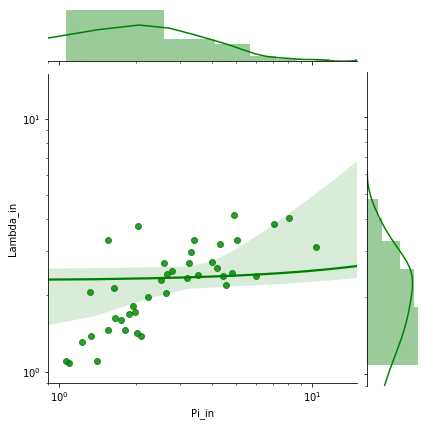

In [18]:
ax = sn.jointplot(dff["Pi_in"], dff["Lambda_in"], kind="reg", color="g")
ax.ax_joint.set(xlim=[0.9, 15.0], ylim=[0.9, 15.0], xscale="log", yscale="log")
ax.ax_joint.set_aspect("equal")

In [19]:
from matplotlib import pyplot as plt

In [20]:
sn.set_context("poster")

In [21]:
from scipy.stats import gaussian_kde
from matplotlib.colors import PowerNorm

Since we are plotting $\Pi$–$\Lambda$ in logarithmic space, we want to calculate the KDE in log space also.  Otherwise, the smoothing will seem to be larger for lower values of $\Pi$, $\Lambda$.

In [22]:
import seaborn.distributions

# Save original version of KDE function
smkde_original = seaborn.distributions._statsmodels_bivariate_kde


def smkde_logxy(x, y, bw, gridsize, cut, clip):
    """Calculate KDE on logarithmic grid for x and y"""
    xx, yy, z = smkde_original(np.log10(x), np.log10(y), bw, gridsize, cut, clip)
    xx = 10 ** xx
    yy = 10 ** yy
    return xx, yy, z


# Monkey patch the function that sns.kdeplot uses to calculate the KDE
seaborn.distributions._statsmodels_bivariate_kde = smkde_logxy

<ipython-input-23-66b1bb46313a>:5: RuntimeWarning: invalid value encountered in sqrt
  R90_T1_grid = np.sqrt(2 * Rc_grid - 1.0)


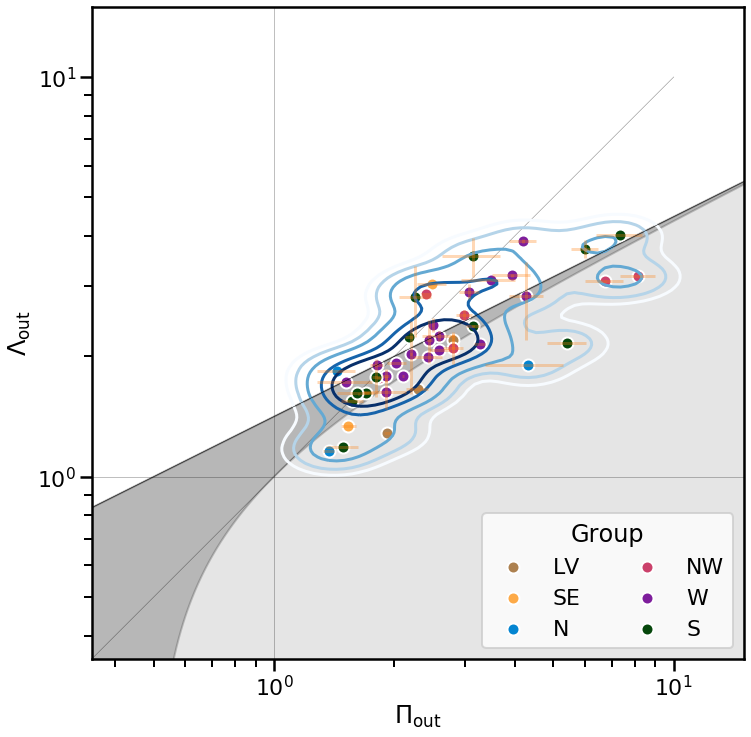

In [23]:
fig, ax = plt.subplots(figsize=(12, 12))

Rc_grid = np.linspace(0.0, 15.0, 2000)
R90_T0_grid = np.sqrt(2 * Rc_grid)
R90_T1_grid = np.sqrt(2 * Rc_grid - 1.0)
R90_T1_grid[~np.isfinite(R90_T1_grid)] = 0.0

ax.fill_between(Rc_grid, R90_T1_grid, R90_T0_grid, color="k", alpha=0.2)
ax.fill_between(Rc_grid, R90_T0_grid, color="k", alpha=0.1)
ax.plot(Rc_grid, R90_T0_grid, c="k", lw=0.5)
ax.axhline(1.0, lw=0.5, alpha=0.5, color="k", zorder=-1)
ax.axvline(1.0, lw=0.5, alpha=0.5, color="k", zorder=-1)
ax.plot([0.0, 10.0], [0.0, 10.0], lw=0.5, alpha=0.5, color="k", zorder=-1)


m = np.isfinite(dff["Pi_out"]) & np.isfinite(dff["Lambda_out"])
sn.kdeplot(
    dff[m]["Pi_out"],
    dff[m]["Lambda_out"],
    ax=ax,
    bw=(0.07, 0.035),
    levels=[0.5, 1.0, 2.0, 4.0, 6.0],
    norm=PowerNorm(0.5),
    cmap="Blues",
)

ax.errorbar(
    x=dff["Pi_out"],
    y=dff["Lambda_out"],
    xerr=dff["e_Pi_out"],
    yerr=dff["d_Lambda_out"],
    fmt="none",
    alpha=0.3,
)

groups = [
    "LV",
    "SE",
    "N",
    "NW",
    "W",
    "S",
]
colors = [
    "light brown",
    "light orange",
    "cerulean",
    "dark pink",
    "purple",
    "forest green",
]
colors = sn.xkcd_palette(colors)
groups_and_colors = list(zip(groups, colors))


for group, color in groups_and_colors:
    m = dff["Group"] == group
    ax.scatter(
        x=dff[m]["Pi_out"],
        y=dff[m]["Lambda_out"],
        marker="o",
        c=[color],
        label=group,
        edgecolors="w",
    )
ax.legend(ncol=2).set_title("Group")
ax.set(xlim=[0.35, 15.0], ylim=[0.35, 15.0], xscale="log", yscale="log")
ax.set_aspect("equal")
ax.set(xlabel=r"$\Pi_\mathrm{out}$", ylabel=r"$\Lambda_\mathrm{out}$")

fig.savefig(ROOT_PATH / "all-sources-new-Pi_out-Lambda_out.pdf")

<ipython-input-24-76cdf0f5ddf5>:6: RuntimeWarning: invalid value encountered in sqrt
  R90_T1_grid = np.sqrt(2 * Rc_grid - 1.0)


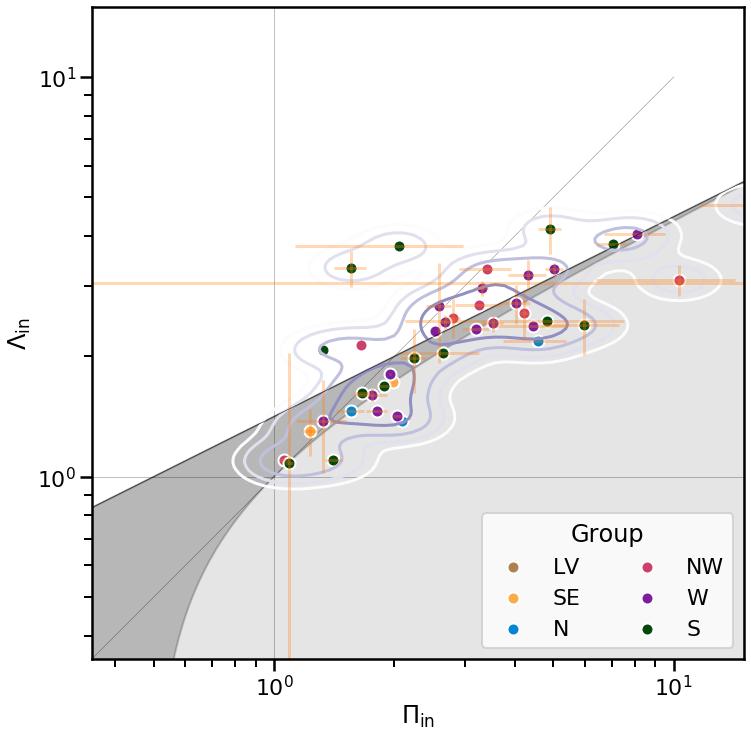

In [24]:
fig, ax = plt.subplots(figsize=(12, 12))


Rc_grid = np.linspace(0.0, 15.0, 2000)
R90_T0_grid = np.sqrt(2 * Rc_grid)
R90_T1_grid = np.sqrt(2 * Rc_grid - 1.0)
R90_T1_grid[~np.isfinite(R90_T1_grid)] = 0.0

ax.fill_between(Rc_grid, R90_T1_grid, R90_T0_grid, color="k", alpha=0.2)
ax.fill_between(Rc_grid, R90_T0_grid, color="k", alpha=0.1)
ax.plot(Rc_grid, R90_T0_grid, c="k", lw=0.5)
ax.axhline(1.0, lw=0.5, alpha=0.5, color="k", zorder=-1)
ax.axvline(1.0, lw=0.5, alpha=0.5, color="k", zorder=-1)
ax.plot([0.0, 10.0], [0.0, 10.0], lw=0.5, alpha=0.5, color="k", zorder=-1)


m = np.isfinite(dff["Pi_in"]) & np.isfinite(dff["Lambda_in"])
sn.kdeplot(
    dff[m]["Pi_in"],
    dff[m]["Lambda_in"],
    ax=ax,
    bw=(0.07, 0.035),
    levels=[0.5, 1.0, 2.0, 4.0, 8.0, 12.0],
    norm=PowerNorm(0.5),
    cmap="Purples",
)


ax.errorbar(
    x=dff["Pi_in"],
    y=dff["Lambda_in"],
    xerr=dff["e_Pi_in"],
    yerr=dff["d_Lambda_in"],
    fmt="none",
    alpha=0.3,
)

for group, color in groups_and_colors:
    m = dff["Group"] == group
    ax.scatter(
        x=dff[m]["Pi_in"],
        y=dff[m]["Lambda_in"],
        marker="o",
        c=[color],
        label=group,
        edgecolors="w",
    )
ax.legend(ncol=2).set_title("Group")
ax.set(xlim=[0.35, 15.0], ylim=[0.35, 15.0], xscale="log", yscale="log")
ax.set_aspect("equal")
ax.set(xlabel=r"$\Pi_\mathrm{in}$", ylabel=r"$\Lambda_\mathrm{in}$")
fig.savefig(ROOT_PATH / "all-sources-new-Pi_in-Lambda_in.pdf")

In [25]:
groups_and_colors

[('LV', (0.6784313725490196, 0.5058823529411764, 0.3137254901960784)),
 ('SE', (0.9921568627450981, 0.6666666666666666, 0.2823529411764706)),
 ('N', (0.01568627450980392, 0.5215686274509804, 0.8196078431372549)),
 ('NW', (0.796078431372549, 0.2549019607843137, 0.4196078431372549)),
 ('W', (0.49411764705882355, 0.11764705882352941, 0.611764705882353)),
 ('S', (0.023529411764705882, 0.2784313725490196, 0.047058823529411764))]

Look at which sources to not have valid outer alatude, $\Lambda_\mathrm{out}$

In [26]:
" ".join(dff[~np.isfinite(dff["Lambda_out"])]["Object"].to_list())

'022-635 049-143 074-229 101-233 124-131 138-3024 154-240 158-323 159-221 165-235 166-316 168-328 169-338 170-249 177-341 178-258 206-043 305-811 362-3137 4285-458 4520-419 4531-628 w044-527'

In [27]:
" ".join(dff[~np.isfinite(dff["Lambda_in"])]["Object"].to_list())

'022-635 066-3251 074-229 101-233 124-131 154-225 158-323 161-324 163-222 163-317 165-235 166-316 167-317 168-326 168-328 169-338 170-249 177-341 206-043 305-811 4285-458 4520-419 4531-628 4582-635 w030-524 w044-527'

In [28]:
" ".join(
    dff[(np.isfinite(dff["Lambda_out"])) & (~np.isfinite(dff["d_Lambda_out"]))][
        "Object"
    ].to_list()
)

'041-637 042-628 051-024 066-3251 102-157 116-3101 119-3155 142-301 154-225 163-222 163-317 167-317 168-326 180-331 189-329 261-3018 308-3036 344-3020 4491-627 4505-336 4550-659 4582-635 w005-514 w012-407 w014-414 w073-227 w266-558'

In [29]:
" ".join(
    dff[(np.isfinite(dff["Lambda_in"])) & (~np.isfinite(dff["d_Lambda_in"]))][
        "Object"
    ].to_list()
)

'041-637 042-628 049-143 051-024 106-245 116-3101 119-3155 138-3024 154-240 159-221 178-258 180-331 203-3039 344-3020 362-3137 4468-605 4491-627 4505-336 4550-659 LL7 w012-407 w073-227 w266-558'

In [30]:
def flag(x):
    return np.char.array(np.where(np.isfinite(x), "🟨", "⬜️"))

In [31]:
flag(dff.Lambda_out) + flag(dff.d_Lambda_out) + flag(dff.Lambda_in) + flag(
    dff.d_Lambda_in
)

chararray(['⬜️⬜️⬜️⬜️', '🟨⬜️🟨⬜️', '🟨⬜️🟨⬜️', '⬜️⬜️🟨⬜️', '🟨⬜️🟨⬜️', '🟨⬜️⬜️⬜️',
           '🟨🟨🟨🟨', '⬜️⬜️⬜️⬜️', '⬜️⬜️⬜️⬜️', '🟨⬜️🟨🟨', '🟨🟨🟨⬜️', '🟨🟨🟨🟨',
           '🟨⬜️🟨⬜️', '🟨⬜️🟨⬜️', '⬜️⬜️⬜️⬜️', '🟨🟨🟨🟨', '⬜️⬜️🟨⬜️', '🟨⬜️🟨🟨',
           '🟨⬜️⬜️⬜️', '⬜️⬜️🟨⬜️', '⬜️⬜️⬜️⬜️', '⬜️⬜️🟨⬜️', '🟨🟨⬜️⬜️',
           '🟨⬜️⬜️⬜️', '🟨⬜️⬜️⬜️', '⬜️⬜️⬜️⬜️', '⬜️⬜️⬜️⬜️', '🟨⬜️⬜️⬜️',
           '🟨⬜️⬜️⬜️', '⬜️⬜️⬜️⬜️', '⬜️⬜️⬜️⬜️', '⬜️⬜️⬜️⬜️', '⬜️⬜️⬜️⬜️',
           '⬜️⬜️🟨⬜️', '🟨⬜️🟨⬜️', '🟨⬜️🟨🟨', '🟨🟨🟨⬜️', '⬜️⬜️⬜️⬜️', '🟨⬜️🟨🟨',
           '⬜️⬜️⬜️⬜️', '🟨⬜️🟨🟨', '🟨⬜️🟨⬜️', '⬜️⬜️🟨⬜️', '⬜️⬜️⬜️⬜️', '🟨🟨🟨🟨',
           '🟨🟨🟨⬜️', '🟨⬜️🟨⬜️', '🟨⬜️🟨⬜️', '⬜️⬜️⬜️⬜️', '⬜️⬜️⬜️⬜️', '🟨⬜️🟨⬜️',
           '🟨🟨🟨🟨', '🟨⬜️⬜️⬜️', '🟨🟨🟨🟨', '🟨🟨🟨🟨', '🟨🟨🟨🟨', '🟨🟨🟨🟨', '🟨🟨🟨🟨',
           '🟨🟨🟨🟨', '🟨🟨🟨⬜️', '🟨🟨🟨🟨', '🟨⬜️🟨🟨', '🟨⬜️🟨⬜️', '🟨⬜️🟨🟨', '🟨🟨⬜️⬜️',
           '⬜️⬜️⬜️⬜️', '🟨🟨🟨🟨', '🟨⬜️🟨⬜️', '🟨⬜️🟨⬜️'], dtype='<U8')

In [32]:
dff["Lam_flags"] = (
    flag(dff.Lambda_out)
    + flag(dff.d_Lambda_out)
    + flag(dff.Lambda_in)
    + flag(dff.d_Lambda_in)
)

In [33]:
pd.options.display.max_rows = 999

In [34]:
dff[["Object", "Group", "Folder", "Lam_flags"]]

,Object,Group,Folder,Lam_flags
0,022-635,W,,⬜️⬜️⬜️⬜️
1,041-637,W,,🟨⬜️🟨⬜️
2,042-628,W,,🟨⬜️🟨⬜️
3,049-143,NW,,⬜️⬜️🟨⬜️
4,051-024,NW,,🟨⬜️🟨⬜️
5,066-3251,S,,🟨⬜️⬜️⬜️
6,072-134,NW,,🟨🟨🟨🟨
7,074-229,NW,,⬜️⬜️⬜️⬜️
8,101-233,NW,,⬜️⬜️⬜️⬜️
9,102-157,NW,,🟨⬜️🟨🟨


In [35]:
dff[["Object", "Group", "Folder", "Lam_flags"]].to_csv(
    ROOT_PATH / "missing_lambdas.csv", index=False
)

In [36]:
Path("xx/yy/zz.txt").parent

PosixPath('xx/yy')

## Check for significant differences between inner/outer shapes

Use K-S or Anderson-Darling

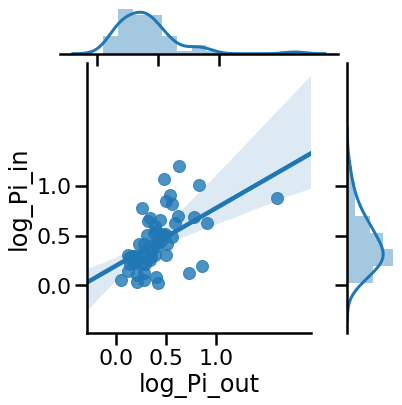

In [38]:
m = dff["Pi_in"] < 20.0
dff["log_Pi_in"] = np.log10(dff["Pi_in"])
dff["log_Pi_out"] = np.log10(dff["Pi_out"])
ax = sn.jointplot(dff[m]["log_Pi_out"], dff[m]["log_Pi_in"], kind="reg")
ax.ax_joint.set(
    xticks=[0, 0.5, 1.0],
    yticks=[0, 0.5, 1.0],
    #    xlim=[0.9, 15.0], ylim=[0.9, 15.0],
    #    xscale="log", yscale="log",
)
ax.ax_joint.set_aspect("equal")

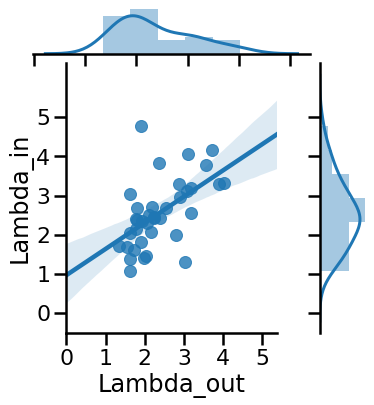

In [39]:
ax = sn.jointplot(dff["Lambda_out"], dff["Lambda_in"], kind="reg")
# ax.ax_joint.set(xlim=[0.9, 15.0], ylim=[0.9, 15.0], xscale="log", yscale="log")
ax.ax_joint.set(
    xticks=[0, 1, 2, 3, 4, 5], yticks=[0, 1, 2, 3, 4, 5],
)
ax.ax_joint.set_aspect("equal")

Import all the stat tests ...

In [40]:
from astropy.stats import kuiper_two
from scipy.stats import ks_2samp, anderson_ksamp, pearsonr, levene

In [41]:
def print_stats(var1, var2):
    m = np.isfinite(dff[var1]) & np.isfinite(dff[var2])
    x, y = dff[m][var1], dff[m][var2]
    _, p_kuiper = kuiper_two(x, y)
    _, p_KS = ks_2samp(x, y)
    _, _, p_AD = anderson_ksamp([x, y], midrank=False)
    _, p_BF = levene(x, y, center="median")
    r_P, p_P = pearsonr(x, y)
    print(
        f"Pearson rank correlation between {var1} and {var2}: {r_P:.5f} (p = {p_P:.5f})"
    )
    print(f"P values for tests of difference between {var1} and {var2}:")
    print("Kuiper test:", np.round(p_kuiper, 5))
    print("Kolmogorov–Smirnov test:", np.round(p_KS, 5))
    print("Anderson–Darling test:", np.round(p_AD, 5))
    print("Brown–Forsyth test (variance):", np.round(p_BF, 5))

In [42]:
print_stats("Pi_out", "Pi_in")

Pearson rank correlation between Pi_out and Pi_in: 0.04395 (p = 0.73664)
P values for tests of difference between Pi_out and Pi_in:
Kuiper test: 0.24718
Kolmogorov–Smirnov test: 0.38794
Anderson–Darling test: 0.23
Brown–Forsyth test (variance): 0.17179


In [43]:
print_stats("Pi_out", "Lambda_out")

Pearson rank correlation between Pi_out and Lambda_out: 0.35045 (p = 0.01695)
P values for tests of difference between Pi_out and Lambda_out:
Kuiper test: 0.36061
Kolmogorov–Smirnov test: 0.22869
Anderson–Darling test: 0.06676
Brown–Forsyth test (variance): 0.12912


In [44]:
print_stats("Lambda_out", "Lambda_in")

Pearson rank correlation between Lambda_out and Lambda_in: 0.55193 (p = 0.00040)
P values for tests of difference between Lambda_out and Lambda_in:
Kuiper test: 0.10925
Kolmogorov–Smirnov test: 0.22559
Anderson–Darling test: 0.25
Brown–Forsyth test (variance): 0.40959


<ipython-input-41-1d155dafc04d>:6: UserWarning: p-value capped: true value larger than 0.25
  _, _, p_AD = anderson_ksamp([x, y], midrank=False)


In [45]:
print_stats("Pi_in", "Lambda_in")

Pearson rank correlation between Pi_in and Lambda_in: 0.27953 (p = 0.06947)
P values for tests of difference between Pi_in and Lambda_in:
Kuiper test: 0.19251
Kolmogorov–Smirnov test: 0.06992
Anderson–Darling test: 0.03609
Brown–Forsyth test (variance): 0.12405


In [46]:
print_stats("Pi_out", "old_Pi_out")

Pearson rank correlation between Pi_out and old_Pi_out: 0.26956 (p = 0.03124)
P values for tests of difference between Pi_out and old_Pi_out:
Kuiper test: 0.99133
Kolmogorov–Smirnov test: 0.944
Anderson–Darling test: 0.25
Brown–Forsyth test (variance): 0.39059


<ipython-input-41-1d155dafc04d>:6: UserWarning: p-value capped: true value larger than 0.25
  _, _, p_AD = anderson_ksamp([x, y], midrank=False)


In [47]:
print_stats("Pi_in", "old_Pi_in")

Pearson rank correlation between Pi_in and old_Pi_in: 0.25910 (p = 0.03869)
P values for tests of difference between Pi_in and old_Pi_in:
Kuiper test: 0.78888
Kolmogorov–Smirnov test: 0.70357
Anderson–Darling test: 0.25
Brown–Forsyth test (variance): 0.1146


<ipython-input-41-1d155dafc04d>:6: UserWarning: p-value capped: true value larger than 0.25
  _, _, p_AD = anderson_ksamp([x, y], midrank=False)


In [48]:
print_stats("log_Pi_out", "log_Pi_in")

Pearson rank correlation between log_Pi_out and log_Pi_in: 0.37879 (p = 0.00261)
P values for tests of difference between log_Pi_out and log_Pi_in:
Kuiper test: 0.24718
Kolmogorov–Smirnov test: 0.38794
Anderson–Darling test: 0.23
Brown–Forsyth test (variance): 0.04586


Next one is a bit silly.  Of course, the difference tests will be significant between one value that is logged and one that isn't ...

In [49]:
print_stats("log_Pi_out", "Lambda_out")
print()
print_stats("log_Pi_in", "Lambda_in")

Pearson rank correlation between log_Pi_out and Lambda_out: 0.68681 (p = 0.00000)
P values for tests of difference between log_Pi_out and Lambda_out:
Kuiper test: 0.0
Kolmogorov–Smirnov test: 0.0
Anderson–Darling test: 0.001
Brown–Forsyth test (variance): 0.0

Pearson rank correlation between log_Pi_in and Lambda_in: 0.66781 (p = 0.00000)
P values for tests of difference between log_Pi_in and Lambda_in:
Kuiper test: -0.0
Kolmogorov–Smirnov test: 0.0
Anderson–Darling test: 0.001
Brown–Forsyth test (variance): 0.0


<ipython-input-41-1d155dafc04d>:6: UserWarning: p-value floored: true value smaller than 0.001
  _, _, p_AD = anderson_ksamp([x, y], midrank=False)


### Summary of statistical tests

We use two different types of tests:

1. Pearson rank correlation, which ignores the absolute values, but looks at between-source relative change in the two variables.

2. The difference tests, which *are* sensitive to the absolute values but ignore only look at the two distributions, ignoring the correlations between sources.  Kuiper, K–S, and A–D are mainly sensitive to central tendency, while B–F is sensitive to width.

Prinipal findings are:

* Strong correlation between `Lambda_out` and `Lambda_in`: $r = 0.55$, $p = 0.0004$.  All difference tests non-significant.
* Weaker (but still significant) correlation between `log_Pi_out` and `log_Pi_in`: $r = 0.41$, $p = 0.001$.  Again, all difference tests non-significant.
* `Lambda` versus `Pi` has strong correlation (both out and in).  The Brown–Forsyth test is the only one that shows a significant difference, presumably because `Lambda` does not have the fat tail towards high values that `Pi` has.

Conclusions are that it is fine to merge the outer and inner arc values, since there is no significant difference between the two.

## Merging the inner and outer arcs

We will do this by the following steps

1. Separate out the inner and outer arc columns into two separate data frames
2. Rename `Pi`, `Lambda` (and `d_...`) columns in both to remove `_in` and `_out` suffixes.
3. Add an `Arc` column to each (value `in` or `out`)
4. Concatenate the tables.

In [50]:
VVARS

['Pi', 'Lambda', 'd_Lambda', 'R0']

Steps 1, 2, 3, for outer arcs:

In [51]:
def strip_suffix(s):
    return s.replace("_out", "").replace("_in", "")


COLS = (
    ["Object", "Group", "Folder"]
    + [f"{v}_out" for v in VVARS]
    + [f"e_{v}_out" for v in VVARS]
)
dff_out = dff[COLS].rename(strip_suffix, axis="columns")
dff_out["Arc"] = "out"
dff_out

,Object,Group,Folder,Pi,Lambda,d_Lambda,R0,e_Pi,e_Lambda,e_d_Lambda,e_R0,Arc
0,022-635,W,,3.650357,NaN,NaN,22.700683,0.000000,NaN,NaN,0.000000,out
1,041-637,W,,2.104093,1.790073,NaN,38.138194,0.014239,0.007428,NaN,0.021015,out
2,042-628,W,,1.808089,1.900725,NaN,62.632856,0.067515,0.007162,NaN,0.234756,out
3,049-143,NW,,2.628035,NaN,NaN,25.791173,0.170419,NaN,NaN,0.119471,out
4,051-024,NW,,1.831033,1.769746,NaN,24.115831,0.021157,0.002080,NaN,0.017468,out
5,066-3251,S,,1.486029,1.187195,NaN,22.386348,0.137337,0.006742,NaN,0.270813,out
6,072-134,NW,,2.806504,2.097105,0.180006,97.594700,0.155387,0.169857,0.052413,0.245686,out
7,074-229,NW,,1.145847,NaN,NaN,27.573089,0.000000,NaN,NaN,0.000000,out
8,101-233,NW,,2.249166,NaN,NaN,51.097900,0.833163,NaN,NaN,0.793436,out
9,102-157,NW,,8.143164,3.169951,NaN,16.310516,0.826711,0.023364,NaN,0.056535,out


Steps 1, 2, 3, for inner arcs:

In [52]:
COLS = (
    ["Object", "Group", "Folder"]
    + [f"{v}_in" for v in VVARS]
    + [f"e_{v}_in" for v in VVARS]
)
dff_in = dff[COLS].rename(strip_suffix, axis="columns")
dff_in["Arc"] = "in"
dff_in

,Object,Group,Folder,Pi,Lambda,d_Lambda,R0,e_Pi,e_Lambda,e_d_Lambda,e_R0,Arc
0,022-635,W,,3.101254,NaN,NaN,15.109645,0.000000,NaN,NaN,0.000000,in
1,041-637,W,,4.450772,2.381846,NaN,22.616559,0.958192,0.020438,NaN,0.310400,in
2,042-628,W,,1.947693,1.811044,NaN,35.416102,0.008822,0.001372,NaN,0.011427,in
3,049-143,NW,,1.060232,1.098401,NaN,12.247490,0.032640,0.000175,NaN,0.043226,in
4,051-024,NW,,1.645917,2.141000,NaN,18.048672,0.000000,0.000000,NaN,0.000000,in
5,066-3251,S,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,in
6,072-134,NW,,2.797475,2.500749,0.282141,45.346980,0.120356,0.011820,0.011264,0.143499,in
7,074-229,NW,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,in
8,101-233,NW,,1.945105,NaN,NaN,43.246070,0.000000,NaN,NaN,0.000000,in
9,102-157,NW,,4.220854,2.564675,0.361067,7.938000,0.105343,0.019616,0.058621,0.024100,in


Step 4 to put them both together.

In [53]:
dff_merge = pd.concat([dff_out, dff_in], ignore_index=True)
dff_merge

,Object,Group,Folder,Pi,Lambda,d_Lambda,R0,e_Pi,e_Lambda,e_d_Lambda,e_R0,Arc
0,022-635,W,,3.650357,NaN,NaN,22.700683,0.000000,NaN,NaN,0.000000,out
1,041-637,W,,2.104093,1.790073,NaN,38.138194,0.014239,0.007428,NaN,0.021015,out
2,042-628,W,,1.808089,1.900725,NaN,62.632856,0.067515,0.007162,NaN,0.234756,out
3,049-143,NW,,2.628035,NaN,NaN,25.791173,0.170419,NaN,NaN,0.119471,out
4,051-024,NW,,1.831033,1.769746,NaN,24.115831,0.021157,0.002080,NaN,0.017468,out
5,066-3251,S,,1.486029,1.187195,NaN,22.386348,0.137337,0.006742,NaN,0.270813,out
6,072-134,NW,,2.806504,2.097105,0.180006,97.594700,0.155387,0.169857,0.052413,0.245686,out
7,074-229,NW,,1.145847,NaN,NaN,27.573089,0.000000,NaN,NaN,0.000000,out
8,101-233,NW,,2.249166,NaN,NaN,51.097900,0.833163,NaN,NaN,0.793436,out
9,102-157,NW,,8.143164,3.169951,NaN,16.310516,0.826711,0.023364,NaN,0.056535,out


Now we can plot the merged dataset as before

<ipython-input-54-b5d3abf79a74>:6: RuntimeWarning: invalid value encountered in sqrt
  R90_T1_grid = np.sqrt(2 * Rc_grid - 1.0)


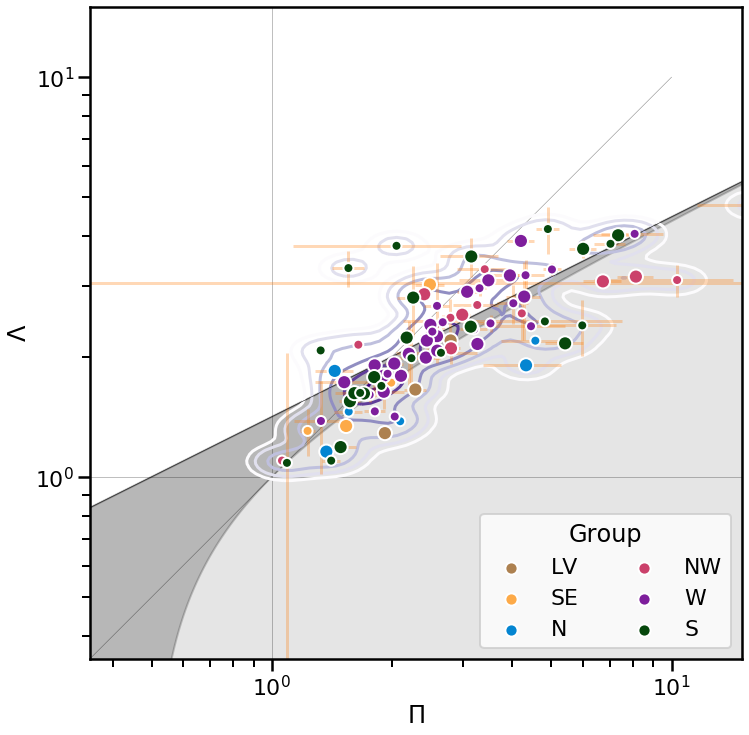

In [54]:
fig, ax = plt.subplots(figsize=(12, 12))


Rc_grid = np.linspace(0.0, 15.0, 2000)
R90_T0_grid = np.sqrt(2 * Rc_grid)
R90_T1_grid = np.sqrt(2 * Rc_grid - 1.0)
R90_T1_grid[~np.isfinite(R90_T1_grid)] = 0.0

ax.fill_between(Rc_grid, R90_T1_grid, R90_T0_grid, color="k", alpha=0.2)
ax.fill_between(Rc_grid, R90_T0_grid, color="k", alpha=0.1)
ax.plot(Rc_grid, R90_T0_grid, c="k", lw=0.5)
ax.axhline(1.0, lw=0.5, alpha=0.5, color="k", zorder=-1)
ax.axvline(1.0, lw=0.5, alpha=0.5, color="k", zorder=-1)
ax.plot([0.0, 10.0], [0.0, 10.0], lw=0.5, alpha=0.5, color="k", zorder=-1)


m = np.isfinite(dff_merge["Pi"]) & np.isfinite(dff_merge["Lambda"])
sn.kdeplot(
    dff_merge[m]["Pi"],
    dff_merge[m]["Lambda"],
    ax=ax,
    bw=(0.05, 0.025),
    levels=[0.5, 1.0, 2.0, 4.0, 8.0, 12.0],
    norm=PowerNorm(0.5),
    cmap="Purples",
    zorder=1,
)


ax.errorbar(
    x=dff_merge["Pi"],
    y=dff_merge["Lambda"],
    xerr=dff_merge["e_Pi"],
    yerr=dff_merge["d_Lambda"],
    fmt="none",
    alpha=0.3,
    zorder=2,
)

sizes = np.empty_like(dff_merge["Pi"])
m = dff_merge["Arc"] == "out"
sizes[m] = 200.0
sizes[~m] = 100.0

for group, color in groups_and_colors:
    m = dff_merge["Group"] == group
    ax.scatter(
        x=dff_merge[m]["Pi"],
        y=dff_merge[m]["Lambda"],
        marker="o",
        c=[color],
        s=sizes[m],
        label=group,
        edgecolors="w",
        zorder=3,
    )
ax.legend(ncol=2).set_title("Group")
ax.set(xlim=[0.35, 15.0], ylim=[0.35, 15.0], xscale="log", yscale="log")
ax.set_aspect("equal")
ax.set(xlabel=r"$\Pi$", ylabel=r"$\Lambda$")
fig.savefig(ROOT_PATH / "all-sources-merge-Pi-Lambda.pdf")

This looks very promising.  We now have enough points that we can reduce the bandwidth (smoothing) of the KDE.

It appears that the shape distribution is bimodal (at least).  There is a cluster at $(\Pi, \Lambda) = (2, 2)$ and another at $(\Pi, \Lambda) \approx (3, 3)$.  Then some outliers around $(1.4, 1.4)$ and other outliers with $\Pi > 5$.

*We should model this with a Gaussian Mixture Model when we have more data.*  (See Jake VdP book)

## Fit Gaussian Cluster Model to shape data

In [73]:
from sklearn.mixture import GaussianMixture as GMM

Put data in form expected by scikit-learn (and without NaNs)

In [74]:
m = np.isfinite(dff_merge["Pi"]) & np.isfinite(dff_merge["Lambda"])
X = np.array(list(zip(np.log10(dff_merge[m]["Pi"]), np.log10(dff_merge[m]["Lambda"]))))

In [75]:
gmm = GMM(n_components=4).fit(X)

In [76]:
labels = gmm.predict(X)

In [77]:
labels

array([1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 2, 2, 0,
       1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 2, 2, 0, 2, 1, 1, 1, 1, 2, 1,
       2, 2, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 0, 2,
       1, 2, 1, 2, 1, 1, 2, 0, 1, 2, 0, 2, 2, 1, 0, 2, 2, 1, 1, 3, 2, 2,
       1])

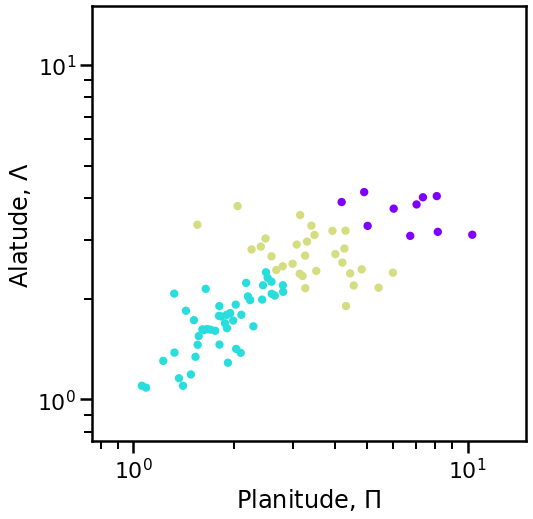

In [78]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(10 ** X[:, 0], 10 ** X[:, 1], c=labels, s=40, cmap="rainbow")
ax.set(
    xscale="log",
    yscale="log",
    xlim=[0.75, 15],
    ylim=[0.75, 15],
    xlabel=r"Planitude, $\Pi$",
    ylabel=r"Alatude, $\Lambda$",
)
ax.set_aspect("equal")

So, using 4 components, it prefers to not separate the (1.4, 1.4) clump, instead fitting one component to the spur, which is probably spurious. It also fits a component to the high-$\Pi$ tail, which is more justified.

### Bayesian Gaussian Mixture to automatically decide how many components

In [79]:
from sklearn.mixture import BayesianGaussianMixture

In [80]:
bgmm = BayesianGaussianMixture(n_components=4, verbose=1).fit(X)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True


In [81]:
bgmm.weights_

array([0.58941299, 0.38350738, 0.02552514, 0.0015545 ])

In [82]:
blabels = bgmm.predict(X)

In [83]:
blabels

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 2, 1, 1,
       1])

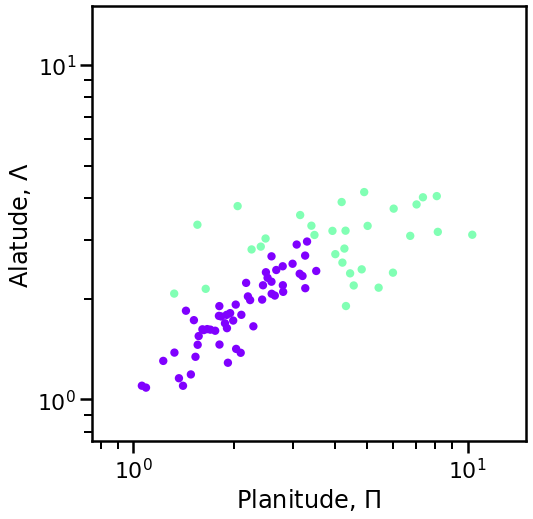

In [84]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(10 ** X[:, 0], 10 ** X[:, 1], c=blabels, s=40, cmap="rainbow")
ax.set(
    xscale="log",
    yscale="log",
    xlim=[0.75, 15],
    ylim=[0.75, 15],
    xlabel=r"Planitude, $\Pi$",
    ylabel=r"Alatude, $\Lambda$",
)
ax.set_aspect("equal")

So, using the default parameters means that it decides that two components are enough.  One (purple) gets the main ridge with \(\Lambda \approx \Pi\), while the other gets the outliers.

In [85]:
bgmm = BayesianGaussianMixture(
    n_components=30, verbose=1, weight_concentration_prior=1000.0
).fit(X)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
Initialization converged: True


In [86]:
bgmm.weights_

array([0.00913367, 0.00912445, 0.00911525, 0.21424664, 0.00909666,
       0.48163956, 0.00907738, 0.00906749, 0.00905762, 0.00904776,
       0.00903791, 0.04068154, 0.02986632, 0.00900833, 0.00899847,
       0.00898861, 0.00897877, 0.00896894, 0.00895912, 0.00894931,
       0.00893952, 0.00892973, 0.00891996, 0.0089102 , 0.00890045,
       0.00889071, 0.00888098, 0.00887126, 0.00886156, 0.00885186])

In [87]:
blabels = bgmm.predict(X)
blabels

array([ 5,  5,  5,  5,  5,  3,  5,  3,  5,  5,  5,  3,  5,  5,  5,  5,  5,
       12,  5,  5,  5,  3,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  3,  5,  5,  5,  5,  5,  3,  5,  5,  3,  3,  5,  5,  5,  5,
        3,  5,  3,  5,  5,  3,  5,  3,  5,  5,  3,  5,  5,  3, 11,  5,  3,
        5,  3,  5,  5,  5,  3,  5,  5,  3,  5,  5,  5,  5, 11,  5,  5,  5,
       12,  3,  5,  3])

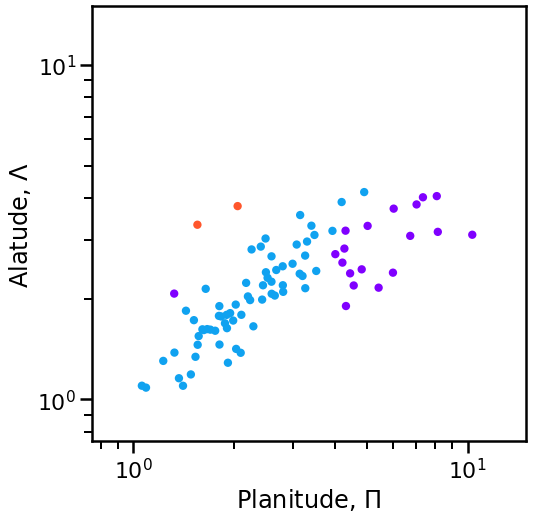

In [88]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(10 ** X[:, 0], 10 ** X[:, 1], c=blabels, s=40, cmap="rainbow")
ax.set(
    xscale="log",
    yscale="log",
    xlim=[0.75, 15],
    ylim=[0.75, 15],
    xlabel=r"Planitude, $\Pi$",
    ylabel=r"Alatude, $\Lambda$",
)
ax.set_aspect("equal")

However much we fiddle with the parameters to try and favor multiple components, it only wants to fit one component to the main diagonal.  Although it can be persuaded to split the outliers up into different components.

### Use pomegranate library to incorporate per-sample weights

With scikit.learn, we can't have different weights for each source (sample in ML parlance).  But we can do that with the pomegranate library.

In [89]:
from pomegranate import GeneralMixtureModel, MultivariateGaussianDistribution

In [90]:
rel_err = np.hypot(
    dff_merge[m]["e_Pi"] / dff_merge[m]["Pi"],
    dff_merge[m]["e_Lambda"] / dff_merge[m]["Lambda"],
)
weights = 1.0 / rel_err ** 2
weights[rel_err == 0.0] = np.nanmedian(weights)
max_weight = 4.0 * np.nanmedian(weights)
weights[weights > max_weight] = max_weight
weights[::10]

1      755.253806
15     755.253806
36     679.852534
52     755.253806
62     221.543949
75     533.809405
90     127.082695
114    265.500937
127    217.870726
dtype: float64

In [91]:
N_COMPONENTS = 4

In [115]:
model = GeneralMixtureModel.from_samples(
    distributions=MultivariateGaussianDistribution,
    n_components=N_COMPONENTS,
    X=X,
    weights=weights,
)

In [116]:
plabels = model.predict(X)
plabels

array([1, 2, 1, 0, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 0, 3, 2, 2, 0, 2, 2, 2,
       1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 3, 0, 2, 1, 0, 2, 2,
       0, 2, 0, 2, 0, 3, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2], dtype=int32)

In [117]:
xmin, xmax = 0.75, 15
ymin, ymax = 0.75, 15
NP = 1000
xx, yy = np.meshgrid(np.linspace(xmin, xmax, NP), np.linspace(ymin, ymax, NP),)
x_ = np.array(list(zip(xx.flatten(), yy.flatten())))
p_components = model.predict_proba(np.log10(x_)).reshape((NP, NP, N_COMPONENTS))
p_tot = model.probability(np.log10(x_)).reshape((NP, NP))
p_tot /= p_tot.max()

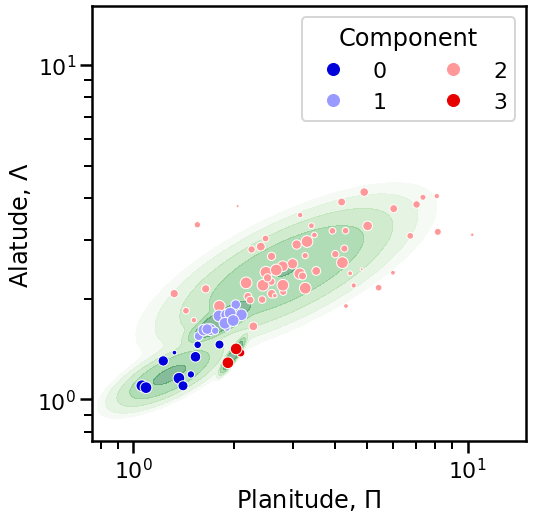

In [118]:
fig, ax = plt.subplots(figsize=(8, 8))
# for k in range(1, N_COMPONENTS):
#    ax.contour(xx, yy, p_components[:, :, k], levels=[0.5], cmap="Reds_r", zorder=-2)
levels = np.array([0.001, 0.003, 0.01, 0.03, 0.1, 1.0])
GAMMA = 0.05
ax.contourf(
    xx, yy, p_tot ** GAMMA, levels=levels ** GAMMA, cmap="Greens", zorder=-1, alpha=0.5
)
scatter = ax.scatter(
    10 ** X[:, 0],
    10 ** X[:, 1],
    c=plabels,
    s=5 * np.sqrt(weights),
    edgecolors="w",
    linewidths=1,
    vmin=-1,
    vmax=4,
    cmap="seismic",
)
ax.set(
    xscale="log",
    yscale="log",
    xlim=[xmin, xmax],
    ylim=[ymin, ymax],
    xlabel=r"Planitude, $\Pi$",
    ylabel=r"Alatude, $\Lambda$",
)
ax.legend(*scatter.legend_elements(), ncol=2, title="Component")
ax.set_aspect("equal")

So it turns out that we *can* get the components that we could intuitively see, by means of using the weights.

However, this is very sensitive to initial conditions.  Re-running the fit can give wildly different decompositions.

In [119]:
for p in range(N_COMPONENTS):
    print("COMPONENT", p)
    print(weights[plabels == p].describe())
    print()

COMPONENT 0
count     10.000000
mean     416.388740
std      280.594074
min       19.808802
25%      161.687256
50%      429.240851
75%      694.093537
max      755.253806
dtype: float64

COMPONENT 1
count     15.000000
mean     541.669940
std      288.787706
min       64.223217
25%      288.876934
50%      755.253806
75%      755.253806
max      755.253806
dtype: float64

COMPONENT 2
count     61.000000
mean     224.516853
std      253.778120
min        0.500204
25%       45.720774
50%      118.558148
75%      244.201177
max      755.253806
dtype: float64

COMPONENT 3
count      3.000000
mean     566.440355
std      327.034491
min      188.813452
25%      472.033629
50%      755.253806
75%      755.253806
max      755.253806
dtype: float64



In [120]:
p_components[:, :, 0].mean()

0.003211894176960376

### Correlation between spatial groups and GMM components



Select just the sources that have $\Pi$ and $\Lambda$ measurements.

In [121]:
df = dff_merge[m].copy()

In [122]:
df["GMM"] = plabels
df["Weight"] = weights
df

,Object,Group,Folder,Pi,Lambda,d_Lambda,R0,e_Pi,e_Lambda,e_d_Lambda,e_R0,Arc,GMM,Weight
1,041-637,W,,2.104093,1.790073,NaN,38.138194,0.014239,0.007428,NaN,0.021015,out,1,755.253806
2,042-628,W,,1.808089,1.900725,NaN,62.632856,0.067515,0.007162,NaN,0.234756,out,2,709.962842
4,051-024,NW,,1.831033,1.769746,NaN,24.115831,0.021157,0.002080,NaN,0.017468,out,1,755.253806
5,066-3251,S,,1.486029,1.187195,NaN,22.386348,0.137337,0.006742,NaN,0.270813,out,0,116.639113
6,072-134,NW,,2.806504,2.097105,0.180006,97.594700,0.155387,0.169857,0.052413,0.245686,out,2,103.887536
9,102-157,NW,,8.143164,3.169951,NaN,16.310516,0.826711,0.023364,NaN,0.056535,out,2,96.515191
10,106-245,NW,,2.994281,2.544668,-0.064376,13.026598,0.138741,0.016342,0.085502,0.046127,out,2,456.997204
11,109-246,NW,,6.734198,3.083743,-0.006321,40.208782,0.742289,0.005236,0.028526,0.201592,out,2,82.285390
12,116-3101,S,,1.568190,1.546107,NaN,29.445332,0.096924,0.024145,NaN,0.199208,out,1,246.068702
13,119-3155,S,,1.699840,1.616185,NaN,60.100153,0.024906,0.011508,NaN,0.037801,out,1,755.253806


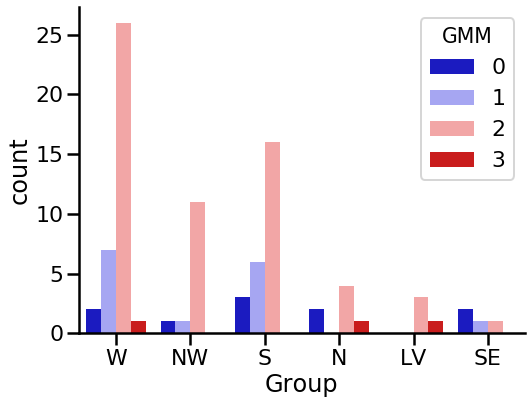

In [123]:
sn.countplot(x="Group", hue="GMM", data=df, palette="seismic")
plt.gcf().set_size_inches(8, 6)
sn.despine()

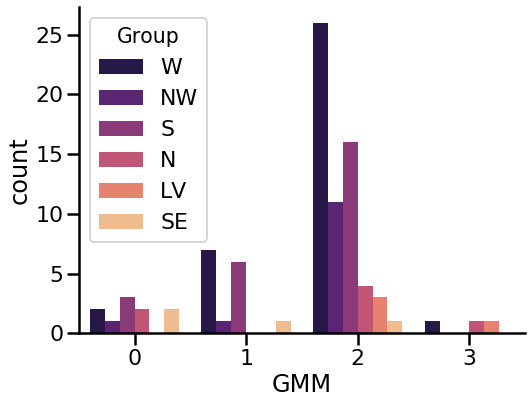

In [124]:
sn.countplot(x="GMM", hue="Group", data=df, palette="magma")
plt.gcf().set_size_inches(8, 6)
sn.despine()

*Note that the labels of the GMM components may have changed since I wrote the following cell*

So there are some slight differences.

The NW group has the majority of component 3, which is the high-$\Lambda$ tail. This is only 3 objects though, so may not be significant.

Component 1, which is the low-$(\Pi, \Lambda)$ clump, has a slight over-representation of the S group, but this is omly 2 objects, so even less significant.

Component 2, which is the compact clump at $(2, 2)$,  also has over-representation of the S group, with 6 sources, which is more significant.

Conponent 0, which is the main diagonal ridge, is dominated by the W group.

Token change to test jupytext.